<a href="https://colab.research.google.com/github/manikandanssp2001/brain-tumor-detection-and-segmentation/blob/main/brain_tumor_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d sushreeswain/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/sushreeswain/brain-tumor-segmentation
License(s): unknown
 40% 9.00M/22.5M [00:00<00:00, 64.1MB/s]
100% 22.5M/22.5M [00:00<00:00, 123MB/s] 


In [ ]:
!unzip /content/brain-tumor-segmentation.zip -d /content/

Archive:  /content/brain-tumor-segmentation.zip
  inflating: /content/Brain Tumour Br35H/annotations_all.json  
  inflating: /content/Brain Tumour Br35H/images/TEST/annotations_test.json  
  inflating: /content/Brain Tumour Br35H/images/TEST/y701.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y702.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y703.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y704.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y705.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y706.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y707.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y708.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y709.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y710.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y711.jpg  
  inflating: /content/Brain Tumour Br35H/images/TEST/y712.jpg  
  inflating: /content/Brain Tumour Br35H/im

In [ ]:
!pip install tensorflow opencv-python matplotlib


In [ ]:
!ls /content/segmentation/images

TEST  TRAIN  VAL


In [ ]:

import os
for dirname, _, filenames in os.walk('/content/segmentation/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/segmentation/annotations_all.json
/content/segmentation/masks/y631.jpg
/content/segmentation/masks/y646.jpg
/content/segmentation/masks/y573.jpg
/content/segmentation/masks/y140.jpg
/content/segmentation/masks/y624.jpg
/content/segmentation/masks/y345.jpg
/content/segmentation/masks/y396.jpg
/content/segmentation/masks/y393.jpg
/content/segmentation/masks/y720.jpg
/content/segmentation/masks/y769.jpg
/content/segmentation/masks/y559.jpg
/content/segmentation/masks/y477.jpg
/content/segmentation/masks/y75.jpg
/content/segmentation/masks/y508.jpg
/content/segmentation/masks/y24.jpg
/content/segmentation/masks/y754.jpg
/content/segmentation/masks/y672.jpg
/content/segmentation/masks/y93.jpg
/content/segmentation/masks/y126.jpg
/content/segmentation/masks/y630.jpg
/content/segmentation/masks/y305.jpg
/content/segmentation/masks/y741.jpg
/content/segmentation/masks/y213.jpg
/content/segmentation/masks/y31.jpg
/content/segmentation/masks/y529.jpg
/content/segmentation/masks/y387.jpg

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, UpSampling2D

In [ ]:
def load_and_prepare_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        try:
            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name)

            if not os.path.exists(mask_path):
                print(f"Mask for image {img_name} not found, skipping.")
                continue

            img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask_array = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            resized_img = cv2.resize(img_array, (128, 128))
            resized_mask = cv2.resize(mask_array, (128, 128))

            rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)

            images.append(rgb_img)
            masks.append(resized_mask)
        except Exception as e:
            print(f"Failed to process image or mask {img_name}: {e}")

    print(f"Loaded {len(images)} images and {len(masks)} masks from {image_dir} and {mask_dir}.")
    return np.array(images), np.array(masks)

In [ ]:
data_dir_images = "/content/segmentation/images/TRAIN"
data_dir_masks = "/content/segmentation/masks"

In [ ]:
images, masks = load_and_prepare_images_and_masks(data_dir_images, data_dir_masks)

images = images / 255.0
masks = masks / 255.0

masks = np.expand_dims(masks, axis=-1)

Mask for image annotations_train.json not found, skipping.
Loaded 500 images and 500 masks from /content/segmentation/images/TRAIN and /content/segmentation/masks.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2)

In [ ]:
def DeeplabV3Plus(input_shape=(128, 128, 3), train_batch_size=4, val_batch_size=2):
    from tensorflow.keras.applications import ResNet50

    base_model = ResNet50(input_shape=input_shape, include_top=False)

    # ASPP layer
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False)(base_model.output)
    b0 = BatchNormalization()(b0)
    b0 = ReLU()(b0)

    x = UpSampling2D((4, 4), interpolation='bilinear')(b0)
    x = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)

    x = UpSampling2D((8, 8), interpolation='bilinear')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=x)

    # Define optimizer with desired learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00000001)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model, train_batch_size, val_batch_size

In [ ]:
model, train_batch_size, val_batch_size = DeeplabV3Plus(train_batch_size=4, val_batch_size=2)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
13/13 [==============================] - 27s 945ms/step - loss: 0.4203 - accuracy: 0.8186 - val_loss: 0.8397 - val_accuracy: 0.9377
Epoch 2/100
13/13 [==============================] - 10s 775ms/step - loss: 0.1220 - accuracy: 0.9484 - val_loss: 0.7668 - val_accuracy: 0.8613
Epoch 3/100
13/13 [==============================] - 10s 770ms/step - loss: 0.0861 - accuracy: 0.9579 - val_loss: 0.5267 - val_accuracy: 0.7172
Epoch 4/100
13/13 [==============================] - 10s 777ms/step - loss: 0.0747 - accuracy: 0.9609 - val_loss: 0.7241 - val_accuracy: 0.6183
Epoch 5/100
13/13 [==============================] - 10s 785ms/step - loss: 0.0707 - accuracy: 0.9622 - val_loss: 0.3115 - val_accuracy: 0.9095
Epoch 6/100
13/13 [==============================] - 10s 757ms/step - loss: 0.0681 - accuracy: 0.9631 - val_loss: 0.2108 - val_accuracy: 0.9377
Epoch 7/100
13/13 [==============================] - 10s 767ms/step - loss: 0.0663 - accuracy: 0.9636 - val_loss: 0.2073 - val_accuracy:

In [ ]:
model.save("tumor_segmentation.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


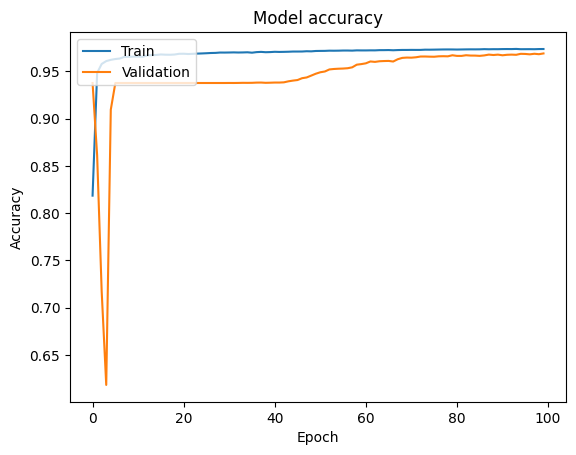

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

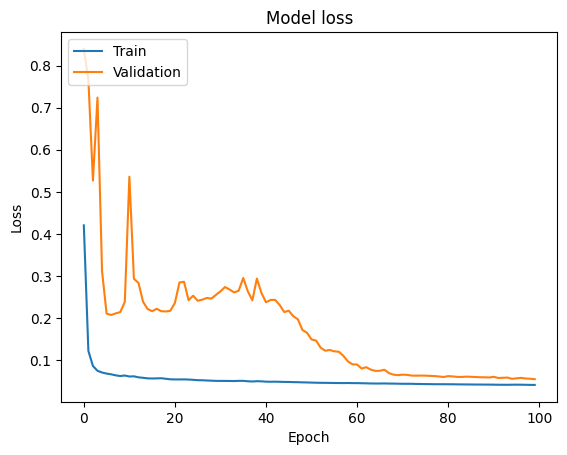

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

4/4 [==============================] - 1s 132ms/step - loss: 0.0548 - accuracy: 0.9690
Test Accuracy: 0.9690045118331909


1/1 [==============================] - 2s 2s/step


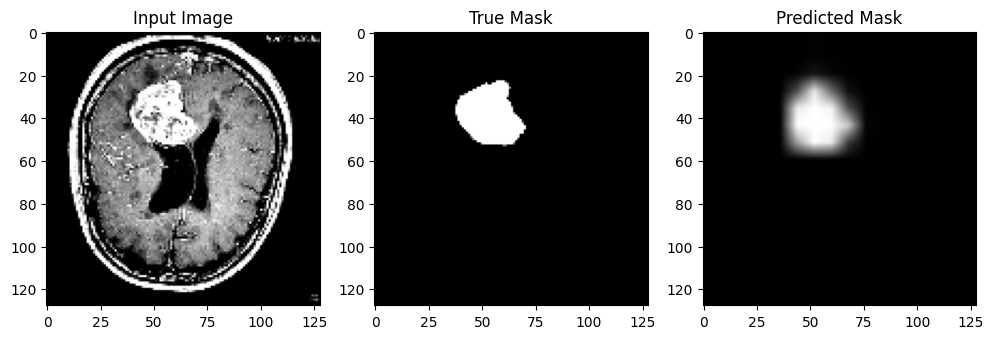

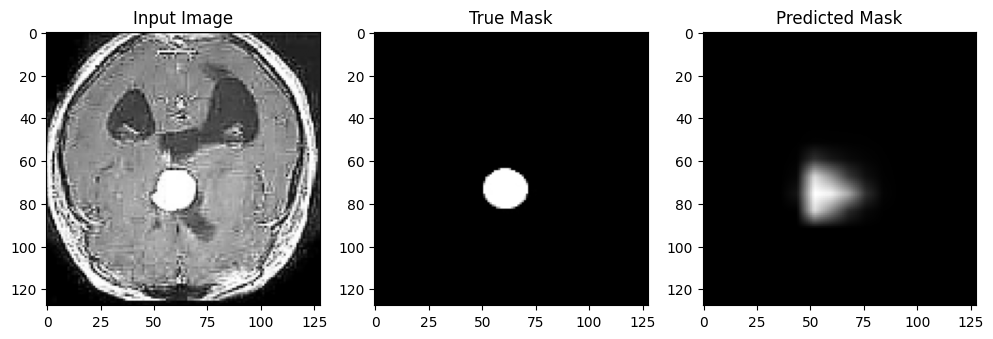

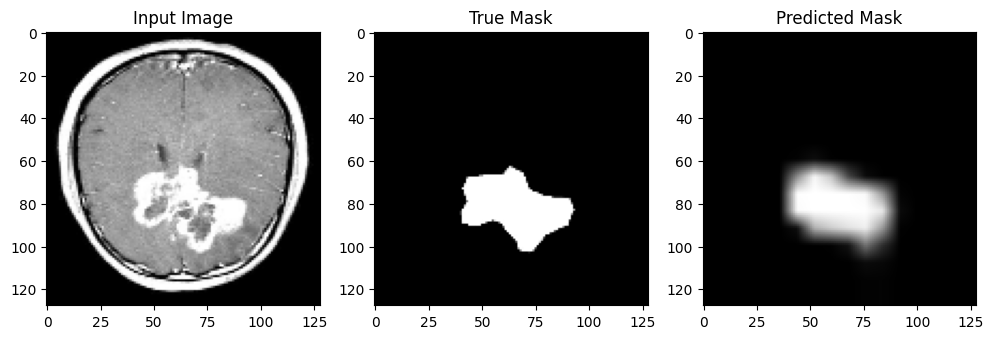

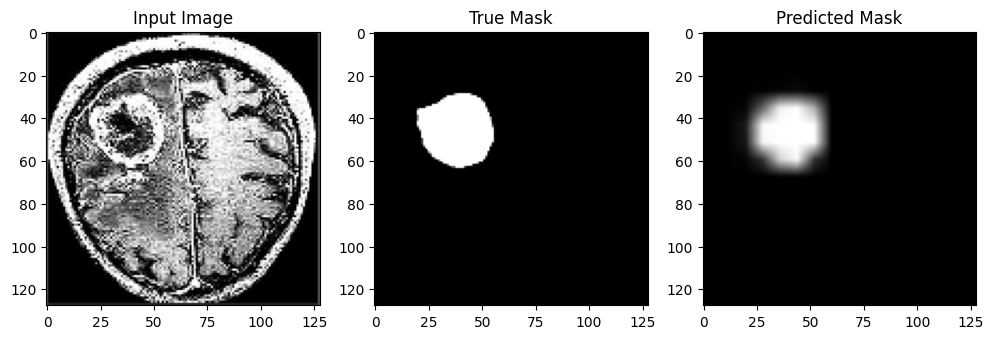

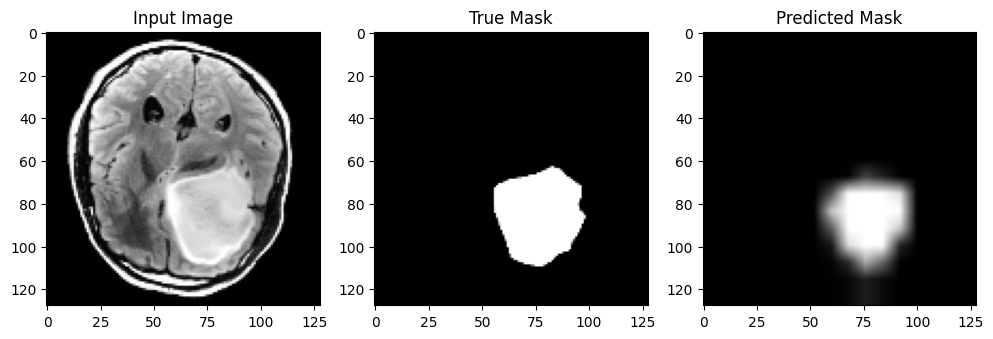

In [ ]:
predictions = model.predict(X_test[:10])
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.show()